#### Computing du score 1 à partir du TMJA national

##### PARTIE 1 : CONSTRUCTION DU GRAPH ET CALCUL DU BETWEENESS

Notebook amorcé par : Jesshuan

Objectifs :

- Récupération de la fonction de "fill missing values" du tmja à partir des précédents notebooks

- grâce aux méthodes de geopandas, génération d'un graph complet du réseau des nationales et autoroutes (fichier tmja) sous Neo4j.

- calcul du Betweeness pour chaque point route

- association, pour chaque point commune, de sa route la plus proche , sa distance à la route, le betweeness de la route

- composition du score 1 pour chaque commune

Imports :

In [2]:
import geopandas as gpd
import pandas as pd
import geopy.distance
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import copy

from neo4j import GraphDatabase, basic_auth

In [3]:
# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
os.makedirs(data_path, exist_ok=True)

In [40]:
# OPTIONNAL : Import et test avec TMJA 2019, qui est un fichier plus incomplet (et routes encore plus discontinues...) que 2018

'''# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')
file_name = 'TMJA2019'
ext = '.shp'
url = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'
temp_path = 'temp_unzip'

try: 
    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))
except:
    # From url
    zip_file = requests.get(url).content
    os.makedirs(temp_path, exist_ok=True)
    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:
        archive.extractall(temp_path)
    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))
    shutil.rmtree(temp_path)

    # From local file
    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))

    # avoiding multi dowloads for GES emmision lowering
    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))'''

"# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')\nfile_name = 'TMJA2019'\next = '.shp'\nurl = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'\ntemp_path = 'temp_unzip'\n\ntry: \n    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))\nexcept:\n    # From url\n    zip_file = requests.get(url).content\n    os.makedirs(temp_path, exist_ok=True)\n    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:\n        archive.extractall(temp_path)\n    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))\n    shutil.rmtree(temp_path)\n\n    # From local file\n    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))\n\n    # avoiding multi dowloads for GES emmision lowering\n    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))"

In [4]:
# Load the data for French garge points
#file_name = 'dataset_charge_points.feather'

#bornes = gpd.read_feather(os.path.join(data_path, file_name))

# Load the data for the communes
#file_name = 'dataset_communes.feather'

#datas = gpd.read_feather(os.path.join(data_path, file_name))

file_name = 'TMJA2018'

tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))

--------

Conversion dans le système ws84 (coordonnées GPS standard) :

In [5]:
tmja_wrs84 = tmja.to_crs(4326)

Remplissage par " capilarité" des missings values du tmja :

In [6]:
def split_and_fill_Local_null_values_by_key(df, column_key, missing_value=0,nb_rep=10, buffer_size=0.01):

    geometry_conservation = df.geometry

    df_clean = copy.copy(df)

    try:
        df_clean.reset_index(names="road_index", inplace=True)
    except Exception as e:
        print(e)
        pass

    df_buf = df_clean.buffer(buffer_size)

    df_clean.geometry = df_buf

    total_values = 0

    for k in range(nb_rep):

        new_column = []
        values = 0

        column_list = df_clean[column_key].to_list()
        index_list = df_clean['road_index'].to_list()

        df_join_road = df_clean.sjoin(df_clean, how='inner')
        df_join_road_clean = df_join_road.loc[df_join_road['road_index_left']!=df_join_road['road_index_right'],:]
        dict_new = df_join_road_clean[['road_index_left',f'{column_key}_right']].groupby('road_index_left').mean().to_dict()[f'{column_key}_right']

        for i, index in enumerate(index_list):
            old_tmja = column_list[i]
            if old_tmja == missing_value or str(old_tmja)==missing_value:
                try:
                    new_column.append(dict_new[index])
                    values+=1
                except:
                    new_column.append(old_tmja)
            else:
                new_column.append(old_tmja)
        
        df_clean[column_key] = new_column
    
        total_values += values

        print(f'... {k+1} rounds done. {values} are been modified... Total values modified : {total_values}')
    
    df_clean.geometry = geometry_conservation

    return df_clean

In [7]:
len(tmja_wrs84.loc[tmja_wrs84['tmja']==0,:])

1544

In [8]:
tmja_wrs84_clean = split_and_fill_Local_null_values_by_key(tmja_wrs84, column_key='tmja', nb_rep=40, buffer_size=0.003)

/tmp/ipykernel_649793/3422367474.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_buf = df_clean.buffer(buffer_size)


... 1 rounds done. 1539 are been modified... Total values modified : 1539
... 2 rounds done. 729 are been modified... Total values modified : 2268
... 3 rounds done. 459 are been modified... Total values modified : 2727
... 4 rounds done. 329 are been modified... Total values modified : 3056
... 5 rounds done. 227 are been modified... Total values modified : 3283
... 6 rounds done. 172 are been modified... Total values modified : 3455
... 7 rounds done. 123 are been modified... Total values modified : 3578
... 8 rounds done. 85 are been modified... Total values modified : 3663
... 9 rounds done. 61 are been modified... Total values modified : 3724
... 10 rounds done. 46 are been modified... Total values modified : 3770
... 11 rounds done. 42 are been modified... Total values modified : 3812
... 12 rounds done. 37 are been modified... Total values modified : 3849
... 13 rounds done. 35 are been modified... Total values modified : 3884
... 14 rounds done. 31 are been modified... Total va

-----

On récupère aussi les centres de routes :

In [9]:
tmja_wrs84_clean['Road_center'] = tmja_wrs84_clean.to_crs('+proj=cea').geometry.centroid.to_crs(tmja_wrs84.crs)

--------------------------

Graph projection :

Functions de préparations pour requêtes vers Neo4j :

In [10]:
def prepare_df_for_graph_without_buffer(df):

    df_join_road = df.sjoin(df, how='inner')
    df_join_road_clean = df_join_road.loc[df_join_road['road_index_left']!=df_join_road['road_index_right'],:]
    
    df_for_graph = df_join_road_clean[['road_index_left','road_index_right', 'Road_center_left', 'Road_center_right']]
    road_center_left_list = df_for_graph['Road_center_left'].geometry
    road_center_right_list = df_for_graph['Road_center_right'].geometry
    dist_centers_list = [geopy.distance.geodesic(coord_1.coords, coord_2.coords).meters for coord_1, coord_2 in zip(road_center_left_list, road_center_right_list)]
    df_for_graph['distance'] = dist_centers_list
    return df_for_graph

In [11]:
def prepare_df_for_graph_with_buffer(df, buffer_size):

    df = copy.copy(tmja_wrs84_clean)
    df_buf = df.buffer(buffer_size)
    df.geometry = df_buf

    df_join_road = df.sjoin(df, how='inner')
    df_join_road_clean = df_join_road.loc[df_join_road['road_index_left']!=df_join_road['road_index_right'],:]
    
    df_for_graph = df_join_road_clean[['road_index_left','road_index_right', 'Road_center_left', 'Road_center_right']]
    road_center_left_list = df_for_graph['Road_center_left'].geometry
    road_center_right_list = df_for_graph['Road_center_right'].geometry
    dist_centers_list = [geopy.distance.geodesic(coord_1.coords, coord_2.coords).meters for coord_1, coord_2 in zip(road_center_left_list, road_center_right_list)]
    df_for_graph['distance'] = dist_centers_list
    return df_for_graph

Création des noeuds/relations, d'abord sans buffer de geopandas :

In [224]:
df_for_graph_exact_join = prepare_df_for_graph_without_buffer(tmja_wrs84_clean)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [225]:
len(tmja_wrs84_clean['road_index'])

5968

In [226]:
len(df_for_graph_exact_join['road_index_left'].unique())

5943

In [227]:
len(df_for_graph_exact_join['road_index_right'].unique())

5943

In [228]:
nodes_list=tmja_wrs84_clean['road_index'].to_list()

Fonctions de requêtes neo4j :

In [300]:
def delete_all(tx):
    query = 'MATCH (n) \
                DETACH DELETE n \
                RETURN count(*) AS COUNT'
    result = tx.run(query)
    return result.data()

In [301]:
def create_node(tx, node):
    query = "   WITH $node AS node \
                CREATE (r:ROAD {road_index:node}) \
                RETURN count(r) AS COUNT"
    
    result = tx.run(query, node=node)
    return result.data()

In [302]:
def create_relationships(tx, props_list):
    query = "   UNWIND $props_list AS map \
                MATCH (n_1:ROAD) WHERE n_1.road_index = map.road_index_left \
                MATCH (n_2:ROAD) WHERE n_2.road_index = map.road_index_right \
                MERGE (n_1)-[r:LINKED_TO]-(n_2) \
                SET r = map \
                RETURN count(r) AS COUNT"
    
    result = tx.run(query, props_list = props_list)
    return result.data()

In [14]:
def match_alone_nodes(tx):
    query = " MATCH (r) \
            WHERE NOT (r)-[:LINKED_TO]-() \
            RETURN r.road_index AS road_index"
    
    result = tx.run(query)
    return result.data()

Drivers session for Neo4j :

In [12]:
driver = GraphDatabase.driver(
  "bolt://localhost:7687",
  auth=basic_auth("neo4j", "passwordneo4j"))

Ardoise (pour effacer tout ancien graph)

In [307]:
with driver.session() as session:

    count_list = []

    result = session.execute_write(delete_all)

driver.close()

nb_nodes = result[0]['COUNT']
                
print(f'Total Numbers of deleted nodes: {nb_nodes}')

Total Numbers of deleted nodes: 5968


Création des noeuds routes :

In [308]:
with driver.session() as session:

    count_list = []

    for node in nodes_list:

        result = session.execute_write(create_node, node)
        count_list.append(result[0]['COUNT'])

driver.close()

nb_nodes = sum(count_list)
                
print(f'Total Numbers of nodes created/updates: {nb_nodes}')

Total Numbers of nodes created/updates: 5968


Création des relations entre routes avec le dataframe sans buffer :

In [309]:
props_list = df_for_graph_exact_join[['road_index_left','road_index_right','distance']].sort_values('distance', ascending=True).to_dict('records')

In [310]:
with driver.session() as session:

    result = session.execute_write(create_relationships, props_list)

driver.close()

nb_rel = result[0]['COUNT']

print(f'Total Numbers of relationships created/updates: {nb_rel}')  



Total Numbers of relationships created/updates: 12026


On regarde le nombres de noeuds orphelins :

In [311]:
with driver.session() as session:

    result = session.execute_write(match_alone_nodes)

driver.close()

print(f'Total Numbers of alone nodes: {len(result)}')  

Total Numbers of alone nodes: 25


In [312]:
alone_nodes = pd.DataFrame(result)['road_index'].to_list()

On réitère le processus pour les noeuds orphelins, en trouvant un stratagème pour éviter la multiplication des neouds...

Définition d'un buffer -size adéquat en geopandas, pour agrandir les points routes

In [313]:
df_for_alone_nodes = prepare_df_for_graph_with_buffer(tmja_wrs84_clean, buffer_size=0.1)

/tmp/ipykernel_291858/3472978905.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_buf = df.buffer(buffer_size)
/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


On ne garde que les lignes du dataframe où se trouvent des noeuds orphelins, et on ordonne le tout par distance, pour prioritiser les relations à construire sur ces neouds :

In [315]:
to_keep = (df_for_alone_nodes['road_index_left'].isin(alone_nodes)) | (df_for_alone_nodes['road_index_right'].isin(alone_nodes))

df_alone_buffer = df_for_alone_nodes.loc[to_keep, :].sort_values('distance')

In [316]:
df_alone_buffer

,road_index_left,road_index_right,Road_center_left,Road_center_right,distance
5544,5544,5543,POINT (3.13463 50.62348),POINT (3.13496 50.62338),38.338070
5543,5543,5544,POINT (3.13496 50.62338),POINT (3.13463 50.62348),38.338070
5543,5543,5541,POINT (3.13496 50.62338),POINT (3.13559 50.62162),207.033320
5541,5541,5543,POINT (3.13559 50.62162),POINT (3.13496 50.62338),207.033320
5544,5544,5541,POINT (3.13463 50.62348),POINT (3.13559 50.62162),232.140783
...,...,...,...,...,...
801,801,5544,POINT (3.35149 50.43639),POINT (3.13463 50.62348),31740.017987
5412,5412,4993,POINT (-2.20416 48.42859),POINT (-2.00816 48.63950),31940.612682
4993,4993,5412,POINT (-2.00816 48.63950),POINT (-2.20416 48.42859),31940.612682
256,256,2571,POINT (4.88466 46.47649),POINT (4.84625 46.77432),33306.582504


On lance un algo qui permet de détecter un noeud orphelin dans une relation (à droite ou à gauche) une est une seule fois, grâce à une collection peu à peu construite :

In [317]:
road_index_left_list = df_alone_buffer['road_index_left'].tolist()
road_index_right_list = df_alone_buffer['road_index_right'].tolist()
length_df_alone = len(df_alone_buffer)
alone_index_viewed = set()

result_control_list = []

for index_left, index_right in zip(road_index_left_list, road_index_right_list):
    if index_left in alone_nodes and index_left not in alone_index_viewed \
        and index_right not in alone_nodes :
        result_control_list.append(True)
        alone_index_viewed.add(index_left)
    elif index_right in alone_nodes and index_right not in alone_index_viewed \
        and index_left not in alone_nodes :
        result_control_list.append(True)
        alone_index_viewed.add(index_right)
    else:
        result_control_list.append(False)

df_alone_buffer['control_view'] = result_control_list

Réduction du dataframe aux relations à construire, qui impliquent une et une seule fois chaque neoud orphelin :

In [319]:
df_alone_buffer = df_alone_buffer.loc[df_alone_buffer['control_view']==True,:]
df_alone_buffer.drop(['control_view'], axis=1, inplace=True)
df_alone_buffer

/tmp/ipykernel_291858/3334822826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alone_buffer.drop(['control_view'], axis=1, inplace=True)


,road_index_left,road_index_right,Road_center_left,Road_center_right,distance
5543,5543,5541,POINT (3.13496 50.62338),POINT (3.13559 50.62162),207.033320
5544,5544,5541,POINT (3.13463 50.62348),POINT (3.13559 50.62162),232.140783
2849,2849,2850,POINT (4.88275 44.90442),POINT (4.88081 44.90265),290.405376
307,307,4914,POINT (4.91972 43.89277),POINT (4.91556 43.89013),544.723871
257,257,4094,POINT (4.83567 46.36849),POINT (4.84104 46.36406),771.577616
2743,2743,2742,POINT (4.67558 45.82287),POINT (4.66790 45.82536),893.751133
4517,4517,1736,POINT (3.13271 45.77697),POINT (3.14087 45.77790),908.035667
1271,1271,1328,POINT (6.09493 46.13262),POINT (6.09793 46.14129),1016.321305
5949,5949,4440,POINT (3.48388 44.52552),POINT (3.48178 44.51534),1154.640031
2207,2207,1485,POINT (5.68430 45.10724),POINT (5.67525 45.10086),1225.649423


Préparation du dataframe poru le graph sous Neo4j :

In [321]:
props_list = df_alone_buffer[['road_index_left','road_index_right','distance']].to_dict('records')

In [322]:
with driver.session() as session:

    result = session.execute_write(create_relationships, props_list)

driver.close()

nb_rel = result[0]['COUNT']

print(f'Total Numbers of relationships created/updates: {nb_rel}')  

Total Numbers of relationships created/updates: 25


Vérification des neouds orphelins dans le graph :

In [15]:
with driver.session() as session:

    result = session.execute_write(match_alone_nodes)

driver.close()

print(f'Total Numbers of alone nodes: {len(result)}')  

Total Numbers of alone nodes: 0


---------

CALCUL DU BETWEENESS POUR LES NOEUDS DU GRAPH :

fonction de requêtes Neo4j :

In [16]:
def create_projection(tx):
    query = "   CALL gds.graph.project('graph_proj', \
                        'ROAD', \
                        {LINKED_TO: \
                            {properties: 'distance', \
                            orientation: 'UNDIRECTED' \
                            } \
                        }) \
                YIELD graphName, nodeCount AS node_count, relationshipCount AS edges_count "
    
    result = tx.run(query)
    return result.data()

In [17]:
def estimate_betweeness(tx):
    query = "CALL gds.betweenness.stream.estimate('graph_proj', \
        {relationshipWeightProperty: 'distance'}) \
        YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory "
    
    result = tx.run(query)
    return result.data()

In [18]:
def compute_betweeness(tx):
    query = " CALL gds.betweenness.stream('graph_proj', \
            {relationshipWeightProperty: 'distance'}) \
            YIELD nodeId, score \
            RETURN gds.util.asNode(nodeId).road_index AS road_index, score "
    
    result = tx.run(query)
    return result.data()


---------

Nous devons d'abord créer une projection du graph :

In [ ]:
with driver.session() as session:

    result = session.execute_write(create_projection)

driver.close()

print(f'Results : {result}')  

Avant tout, estimation de la mémoire requise :

In [328]:
with driver.session() as session:

    result = session.execute_write(estimate_betweeness)

driver.close()

print(f'Results : {result}')  

Results : [{'nodeCount': 5968, 'relationshipCount': 12076, 'bytesMin': 2153816, 'bytesMax': 2153816, 'requiredMemory': '2103 KiB'}]


Puis application du calcul de Betweeness :

In [20]:
with driver.session() as session:

    result = session.execute_write(compute_betweeness)

driver.close()

print(f'Results : {result}')  

Results : [{'road_index': 0, 'score': 0.0}, {'road_index': 1, 'score': 28074.0}, {'road_index': 2, 'score': 31173.0}, {'road_index': 3, 'score': 1485839.0}, {'road_index': 4, 'score': 672557.0}, {'road_index': 5, 'score': 108433.0}, {'road_index': 6, 'score': 103892.0}, {'road_index': 7, 'score': 103042.0}, {'road_index': 8, 'score': 105883.0}, {'road_index': 9, 'score': 108725.0}, {'road_index': 10, 'score': 111568.0}, {'road_index': 11, 'score': 114411.0}, {'road_index': 12, 'score': 117254.0}, {'road_index': 13, 'score': 863598.0}, {'road_index': 14, 'score': 837381.0}, {'road_index': 15, 'score': 834748.0}, {'road_index': 16, 'score': 832145.0}, {'road_index': 17, 'score': 829555.0}, {'road_index': 18, 'score': 826996.0}, {'road_index': 19, 'score': 824466.0}, {'road_index': 20, 'score': 821942.0}, {'road_index': 21, 'score': 819417.0}, {'road_index': 22, 'score': 816891.0}, {'road_index': 23, 'score': 814364.0}, {'road_index': 24, 'score': 811839.0}, {'road_index': 25, 'score': 80

In [21]:
result_betweeness = pd.DataFrame(result)

In [22]:
list_score_by_index = result_betweeness['score'].to_list()

In [23]:
tmja_wrs84_clean['betweeness'] = list_score_by_index

------------

ANALYSE DU RESULTAT DE BETWEENESS :

In [24]:
fig = px.histogram(tmja_wrs84_clean, x='betweeness')
fig.show()

Distribution trs étirée

In [25]:
fig = px.box(tmja_wrs84_clean, x='betweeness')
fig.show()

Après différentes recherches, on décide d'appliquer une fonction logarithmique, pour standardiser la donnée de manière non-linéaire (il s'agit d'un score, qui est par définition non linéaire)

In [26]:
tmja_wrs84_clean['betweeness_stand'] = np.log(tmja_wrs84_clean['betweeness'] + 1)

In [27]:
fig = px.histogram(tmja_wrs84_clean, x='betweeness_stand')
fig.show()

Affichage brut :

<Axes: >

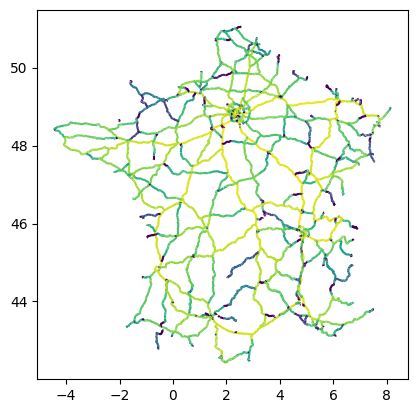

In [28]:
tmja_wrs84_clean.plot(column='betweeness_stand')

Affichage plus pratique avec plotly :

In [29]:
lon_list = []
lat_list = []
for i in range(len(tmja_wrs84_clean['Road_center'])):
    lon_list.append(tmja_wrs84_clean['Road_center'].geometry[i].coords[0][0])
    lat_list.append(tmja_wrs84_clean['Road_center'].geometry[i].coords[0][1])

tmja_wrs84_clean['lat_center'] = lat_list
tmja_wrs84_clean['lon_center'] = lon_list

In [30]:
def fast_visualization_specific_tmja(geo_df, colum_key):

    fig = px.scatter_mapbox(geo_df, lat='lat_center', lon='lon_center', color=colum_key, size=colum_key, mapbox_style='open-street-map')

    fig.show()

In [31]:
fast_visualization_specific_tmja(tmja_wrs84_clean, 'betweeness_stand')

Le résultat semble bon, et le Betweeness fait bien transmettre les "cul-de-sacs" et les routes plus "relais" (ici, indépendamment du traffic)...
À cause de la densité des connexions, à l'approche des grandes villes, le betweeness chute un peu généralement. Cela n'est pas plus mal, car cela traduit le côté "carrefour de croisement" de certaines de ces grandes villes.

Export :

In [32]:
file_name = 'TMJA2018_enriched_and_betweeness'

In [33]:
tmja_wrs84_clean.to_feather(os.path.join(data_path,file_name + '.feather'))